# Importing Libraries

In [1]:
import lightkurve as lk         # LightKurve Python Package to View & Process the Transit Light Curves (Mine is v2.0.11)
import matplotlib.pyplot as plt # Matplotlib for Plotting the Garphs
import numpy as np              # Numpy for Periodogram
import os                       # To provide a path to save or import files in the device

# Downloading the Files

* TIC ID  
The TESS Input Catalogue (TIC) ID serves as an identifier for stars observed with the TESS satellite. TESS Science Processing Operations Center (SPOC) pipeline has been used on raw data obtained from these observations, aiming to identify prominent candidates for exoplanets. These candidates are referred to as TESS Objects of Interest (TOI). Typically, people use the TOI ID to reference the planet or planetary candidate instead of the TIC ID. Name of the planet can be given as TOI-XXXb or TOI-XXXc, d, e etc. Closest planet is b, then next is c, then d, e, f and so on. For example Let's consider Sun is TOI-000 then Mercury is TOI-000b, Venus is TOI-000c, Earth is TOI-000d, Mars is TOI-000e and so on.  


* SPOC  
Since the start of the TESS Mission, the TESS Science Processing Operations Center (SPOC) pipeline has been used to calibrate full-frame images (FFI) and to assign world-coordinate system information to the FFI data delivered to the MAST. The SPOC pipeline has generated target pixel files, light curves, and associated products from two-minute cadence target data, but not from FFIs (Jenkins, et al. 2016). Data provided with this release extend the SPOC pipeline processing to include targets selected from the FFIs to create target pixel and light curve files for up to 160,000 targets per sector.  


* Exposure Time  
The SPOC provides us with light curves at different cadences, namely 30 minutes (1800 seconds) and 2 minutes (120 seconds). Typically, we prefer using the 120-second files. The 30-minute cadence is generally avoided due to the likelihood of star saturation, which can lead to inaccurate or untrustworthy results.

In [2]:
TOI_ID = 2459
file = lk.search_lightcurve("TIC 192790476", author = 'SPOC', exptime = 120).download_all()

# Combining Different Sectors 

Here you may use .stitch() command to join the light curves of a different sectors, but I generally do this. Reason being, here I'm using .download_all() command to download the data from MAST so .stitch() will be usefull for it. But I prefer to download the data on my PC. And then directly call the locally stored data rather than relying on real-time downloads. This practice proves beneficial in scenarios where the MAST website is inaccessible or when internet connectivity is unreliable. The choice of whether to download data directly or use real-time downloads depends on individual preferences and circumstances.

In [3]:
file1 = file[0].normalize()
file2 = file[1].normalize()
file3 = file[2].normalize()
file4 = file[3].normalize()

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

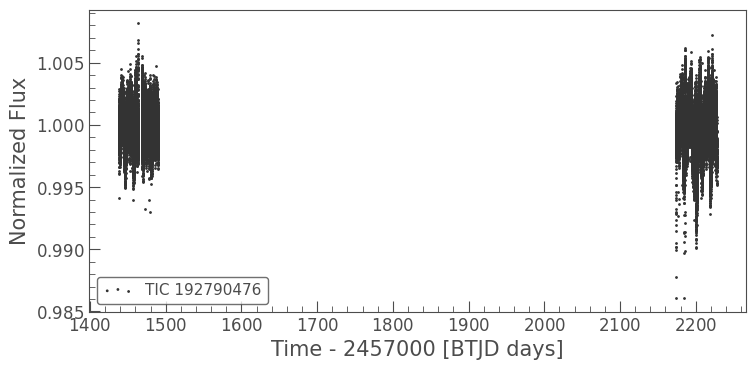

In [4]:
Combined_TOI = file1.append([file2, file3, file4])
Combined_TOI.scatter()

# Periodogram

The periodogram is employed to derive the best-fit period from the data, but its effectiveness can be compromised in the presence of noisy data, leading to inaccurate results. As a precaution, I typically rely on values such as period, epoch time, and duration obtained from ExoFOP for more accurate and reliable information. Nevertheless, for a thorough cross-check, I find it beneficial to plot a periodogram. This additional step helps ensure the consistency of the results and provides a visual confirmation, even though the primary values are sourced from ExoFOP.

`period` contains 1184506 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


 Orbital Period (d) :  11.72000000000001 d 
 Epoch Time (BTJD) :  1445.9361634654379 
 Transit Duration (d) :  0.33 d


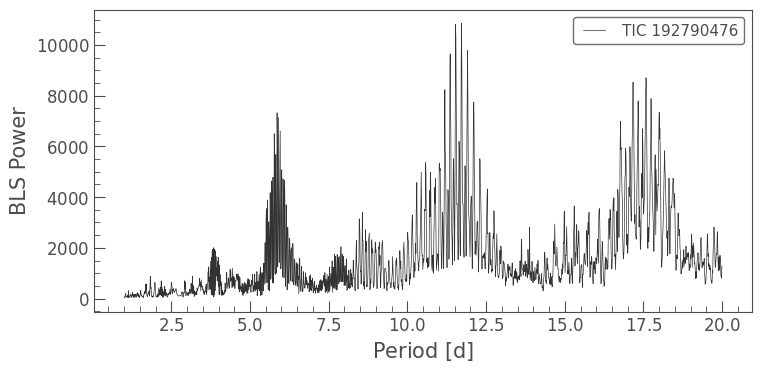

In [5]:
# Create a Periodogram to find out the period of repeated occurrence
# In general find out the period of transit, Epoch time and Transit Durataion

pg = Combined_TOI.to_periodogram(method = 'bls', period = np.arange(1,20,0.01))
pg.plot()

time_period = pg.period_at_max_power
total_transit_time = pg.transit_time_at_max_power
transit_duration = pg.duration_at_max_power

print(" Orbital Period (d) : ", time_period, "\n Epoch Time (BTJD) : ", total_transit_time,\
      "\n Transit Duration (d) : ", transit_duration)

# Masking & Detrending

Certainly, the detrending process is a crucial step, but before applying it, it's essential to mask or remove the transit parts from the light curve. This is because directly detrending without excluding the in-transit portions can lead to unwanted effects on the analysis. The goal is to eliminate unnecessary trends such as solar flux variations and instrumental noise without affecting the data related to transits.

To achieve this, a two-step approach is recommended. First, mask or remove the transit parts from the light curve. Next, perform the detrending process on the remaining data. Once detrending is complete, reintroduce the masked transit parts to ensure that the analysis properly accounts for the in-transit information. This ensures that the detrending process focuses on the relevant portions of the light curve, improving the accuracy of subsequent analyses and interpretations.

`period` contains 1184534 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.




 Orbital Period (d) :  19.104999999998007 d 
 Epoch Time (BTJD) :  1452.336163465438 
 Transit Duration (d) :  0.1 d


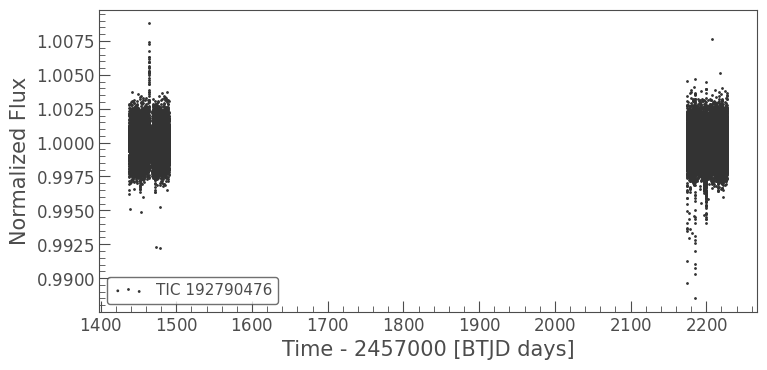

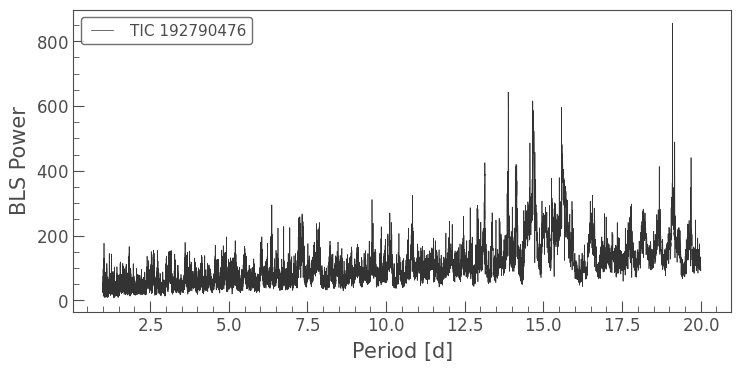

In [6]:
# Based on previous evaluated values we have to mask all the transits and need to de-trend the remaining portion
# In a view to avoide the stellar activity 

# Mask the transits 
# Paste below the data (period, epoch time, transit duration) calculated above.
masked_lc = Combined_TOI.create_transit_mask(period = 19.104718, 
                                             transit_time = 1452.334203609, 
                                             duration = 0.2)

# Detrending the out of transit part
flat_lc = Combined_TOI.flatten(mask = masked_lc, window_length = 1000)
flat_lc.scatter()

# Create the Periodogram of Detrended Light Curve
pg_flatten = flat_lc.to_periodogram(method = 'bls', period = np.arange(1,20,0.001))
pg_flatten.plot()

# Print the evaluated values
time_period = pg_flatten.period_at_max_power
transit_time = pg_flatten.transit_time_at_max_power
transit_duration = pg_flatten.duration_at_max_power
print("\n")
print(" Orbital Period (d) : ",time_period,"\n","Epoch Time (BTJD) : ",transit_time,\
      "\n","Transit Duration (d) : ", transit_duration)

# Phase Folded Light Curve

(0.995, 1.005)

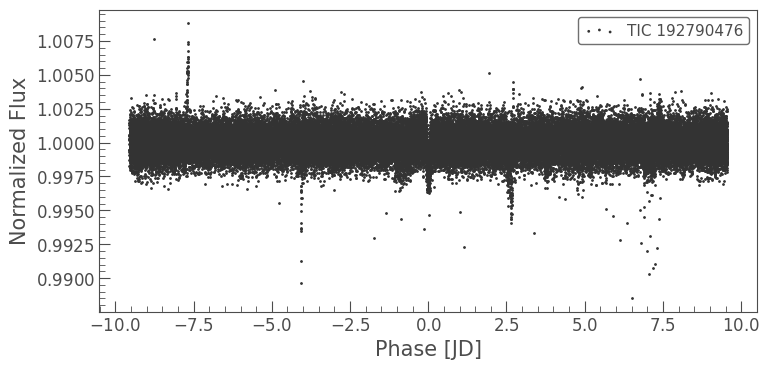

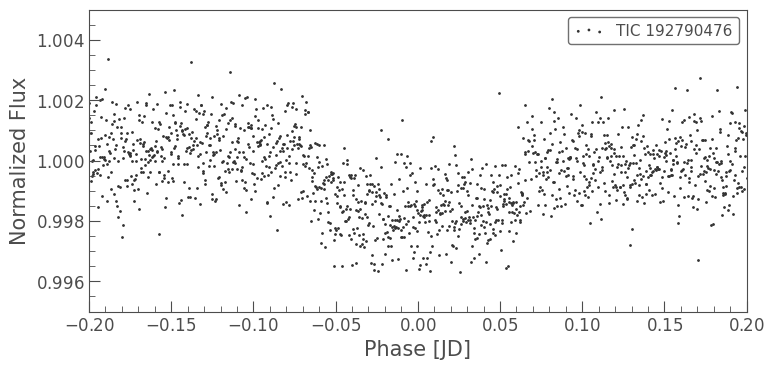

In [7]:
# Fold the light curve based on calculated Time Period & Epoch Time
folded_lc = flat_lc.fold(period = 19.104718, epoch_time = 1452.334203609)

# Plot whole folded light curve
folded_lc.scatter()

# Focused on transit
folded_lc.scatter()
plt.xlim(-0.2,0.2)
plt.ylim(0.9950, 1.0050)

# Saving .fits file for further analysis

In [8]:
# Add columns pdcsap & pdcsap_err to the .fits file
# These two columns will be used while modeling as a raw data
pdcsap = flat_lc.flux
pdcsap_err = flat_lc.flux_err

# Save the File
processed_lc = flat_lc.to_fits(path = 'TOI '+str(TOI_ID)+'.fits', \
                               overwrite = True, pdcsap_flux = pdcsap, pdcsap_flux_err = pdcsap_err)

# Open the file and print
Final_Light_Curve = lk.read('TOI '+str(TOI_ID)+'.fits')
Final_Light_Curve

time,flux,flux_err,pdcsap_flux,pdcsap_flux_err,centroid_col,centroid_row,mom_centr1,mom_centr2,quality
,,electron / s,,,,,,,
object,float64,float32,float64,float64,float64,float64,float64,float64,int32
1437.9814410485958,nan,nan,--,--,--,--,--,--,0
1437.982829965321,nan,nan,--,--,--,--,--,--,0
1437.9842188818131,nan,nan,--,--,--,--,--,--,0
1437.9856077985382,nan,nan,--,--,--,--,--,--,0
1437.9869967152633,nan,nan,--,--,--,--,--,--,0
1437.9883856319884,nan,nan,--,--,--,--,--,--,0
1437.9897745487135,nan,nan,--,--,--,--,--,--,0
1437.991163465438,0.9983877927087133,0.0008105505257844925,0.9983877927087133,0.0008105505183079273,1290.0081055847809,1563.8295073333163,1290.0081055847809,1563.8295073333163,0
